In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
dataframe = pd.read_csv("../input/adult.csv")

To get fair idea about How Data actually looks like! As we can see, there is punctuation for every missig data like in workclass and occupation column. But, to get sure of such things, let's have a look over Info of Pandas Dataframe

In [9]:
dataframe.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df_shape = dataframe.shape
print("DataFrame contains {rows} rows and {cols} columns".format(rows=df_shape[0],
                                                                cols=df_shape[1]))

DataFrame contains 32561 rows and 15 columns


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


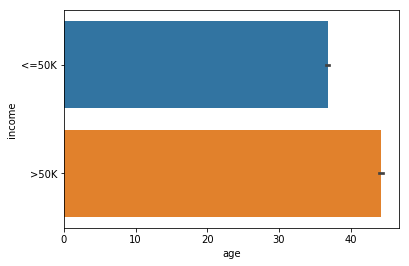

In [6]:
sns.barplot(x='age',y='income',data=dataframe)

1. As per above info about this dataframe, it is clear that there is no NULL values present in the columns. Though, we need to confirm if there are some noise present in the dataset in other forms or not! Let's evaluate and analyse values in the dataset.
2. We can also see that more aged persons have larger income than less aged persons

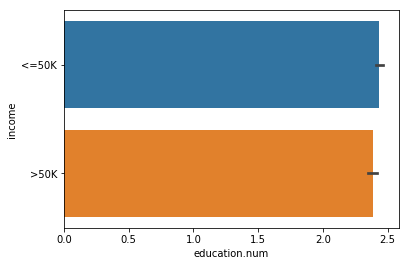

In [8]:
sns.barplot(x='education.num',y='income',data=dataframe,estimator=np.std)

In [ ]:
dataframe[dataframe.age<1]

So, clearly there is no illogical values for Age is present, such as "Age cannot be less than 1"

In [ ]:
for col in dataframe.columns:
    col_datatype = dataframe[col].dtype
    if col_datatype == object:
        print(col,"->", dataframe[col].unique(), end="\n---*---\n")

As per above list, it is clear that "workclass, native.country and occupation" columns contains ambigous value as Punctuation(?) Let's check how many values are affected.

In [ ]:
bool_series = (dataframe["workclass"]=='?') | (dataframe["native.country"]=='?') | (dataframe["occupation"]=='?')
dataframe[bool_series].shape

Total of 2399/32561 records are affected! About 0.07% of the whole dataset which will not affect the data sufficiency if got removed.

In [ ]:
dataframe[dataframe["capital.gain"]<0].shape

In [ ]:
dataframe[dataframe["capital.loss"]<0].shape

Clearly Loss and Gain cannot be negative! Also, dataset indicates none! Cheers. Now, let's get rid of all values by removing all rows containing '?' using bool_serie generated above.

In [ ]:
filter_df = dataframe[~bool_series].copy()

In [ ]:
x = filter_df.drop("income", axis=1)
y = filter_df["income"]

In [ ]:
corr=filter_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, square=True, annot=True)

In [ ]:
x.reset_index(drop=True, inplace=True)
label_enc_dict = dict()
one_hot_enc_dict = dict()
hot_enc_df = pd.DataFrame()
for col in x.columns:
    col_datatype = x[col].dtype
    if col_datatype == object:
        unique_value_list = x[col].unique()
        headers = ["{0}_{1}".format(col, feature) for feature in unique_value_list]
        label_enc_dict[col] = LabelEncoder()
        label_enc_dict[col].fit(x[col])
        label_enc_col = label_enc_dict[col].transform(x[col])
        one_hot_enc_dict[col] = OneHotEncoder(sparse=False)
        label_enc_col = label_enc_col.reshape(len(label_enc_col), 1)
        one_hot_enc_dict[col].fit(label_enc_col)
        one_hot_list = list(one_hot_enc_dict[col].transform(label_enc_col))
        dummy_df = pd.DataFrame(one_hot_list, columns=headers)
        dummy_df.drop(headers[0], axis=1, inplace=True)
        hot_enc_df = pd.concat([hot_enc_df, dummy_df], axis=1)
    else:
        hot_enc_df.reset_index(drop=True, inplace=True)
        hot_enc_df[col] = x[col]

In [ ]:
y_enc = LabelEncoder()
y_label_enc = y_enc.fit_transform(y)
label_enc_dict["income"] = y_enc

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(hot_enc_df, y_label_enc, test_size=0.2, random_state=0)

In [ ]:
classifier = DecisionTreeClassifier()
parameters = {
    'criterion': ("gini", "entropy"),
    'splitter': ("best", "random")}

In [ ]:
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
classifier = DecisionTreeClassifier(criterion="entropy", splitter="best")
classifier.fit(x_train, y_train)

In [ ]:
score = classifier.score(x_test, y_test)
print("Classifier Score: {}%".format(round(score*100, 2)))

In [ ]:
y_pred=classifier.predict(x_test)

In [ ]:
label_enc_dict["income"].inverse_transform(y_pred)